2장에서 구현한 preprocess 함수를 사용합니다.

문장을 통해 corpus를 만들고, id에 맞추어 단어를 부여합니다.<br>
중복되는 단어는 물론 새로 id가 부여되지 않습니다.

In [1]:
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [2]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [3]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 맥락과 타깃을 구별하는 함수 작성

In [4]:
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [5]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [6]:
print(target)

[1 2 3 4 1 5]


### id를 원핫표현으로 변경하자

In [7]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [8]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 3-4 CBOW 모델 구현

In [9]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [11]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [12]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [13]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

###  Trainer 구현

In [14]:
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [20]:
import time
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        plt.rc('font', family='NanumGothic') # For Windows
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

In [21]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [22]:
%matplotlib inline

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 273 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 274 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 275 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 276 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 277 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 278 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 279 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 280 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 281 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 282 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 283 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 284 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 285 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 286 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 287 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 288 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 289 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 290 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 291 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 292 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 293 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 294 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 295 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 296 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 297 |  반복 1

| 에폭 553 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 554 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 555 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 556 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 557 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 558 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 559 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 560 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 561 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 562 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 563 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 564 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 565 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 566 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 567 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 568 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 569 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 570 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 571 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 572 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 573 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 574 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 575 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 576 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 577 |  반복 1

| 에폭 833 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 834 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 835 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 836 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 837 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 838 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 839 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 840 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 841 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 842 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 843 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 844 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 845 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 846 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 847 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 848 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 849 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 850 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 851 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 852 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 853 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 854 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 855 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 856 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 857 |  반복 1

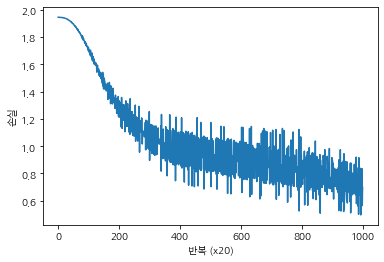

you [1.702719  1.0074373 1.0289094 1.0323255 1.0673217]
say [-1.3587451 -1.0275195 -1.1267393 -1.0653677 -1.093347 ]
goodbye [-0.20993167  1.079364    0.95676684  1.0328835   1.002684  ]
and [-1.1844801 -1.3278842 -0.7573363 -1.2411209 -0.9567586]
i [-0.1891843   1.0452974   0.94532716  1.0265797   1.0008092 ]
hello [1.7092875 1.002761  1.0290104 1.02557   1.0599029]
. [-1.1396805   0.01020154 -1.2317339  -0.26536512 -0.89422184]


In [23]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])